# Single-Cell RNA-seq Analysis of Mouse Spinal Cord

**Dataset:** Sathyamurthy et al. (2018) - GSE103892

This notebook analyzes single-nucleus RNA-seq data from mouse spinal cord to characterize cell type diversity and opioid receptor expression patterns.

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=100, facecolor='white')

## Load Data

Data downloaded from GEO (GSE103892). Count matrix has genes as rows, cells as columns.

In [2]:
counts = pd.read_csv('data/counts.txt', sep='\t', index_col=0)
meta = pd.read_csv('data/metadata.txt', sep='\t', index_col=0)

adata = sc.AnnData(counts.T)
adata.obs = meta.loc[adata.obs_names]

print(f'Loaded: {adata.n_obs} cells, {adata.n_vars} genes')

Loaded: 18000 cells, 32962 genes


## Quality Control

Remove cells flagged by authors and filter based on:
- Gene counts: 200-5000 (remove empty droplets and doublets)
- Mitochondrial content: <20% (remove dying cells)

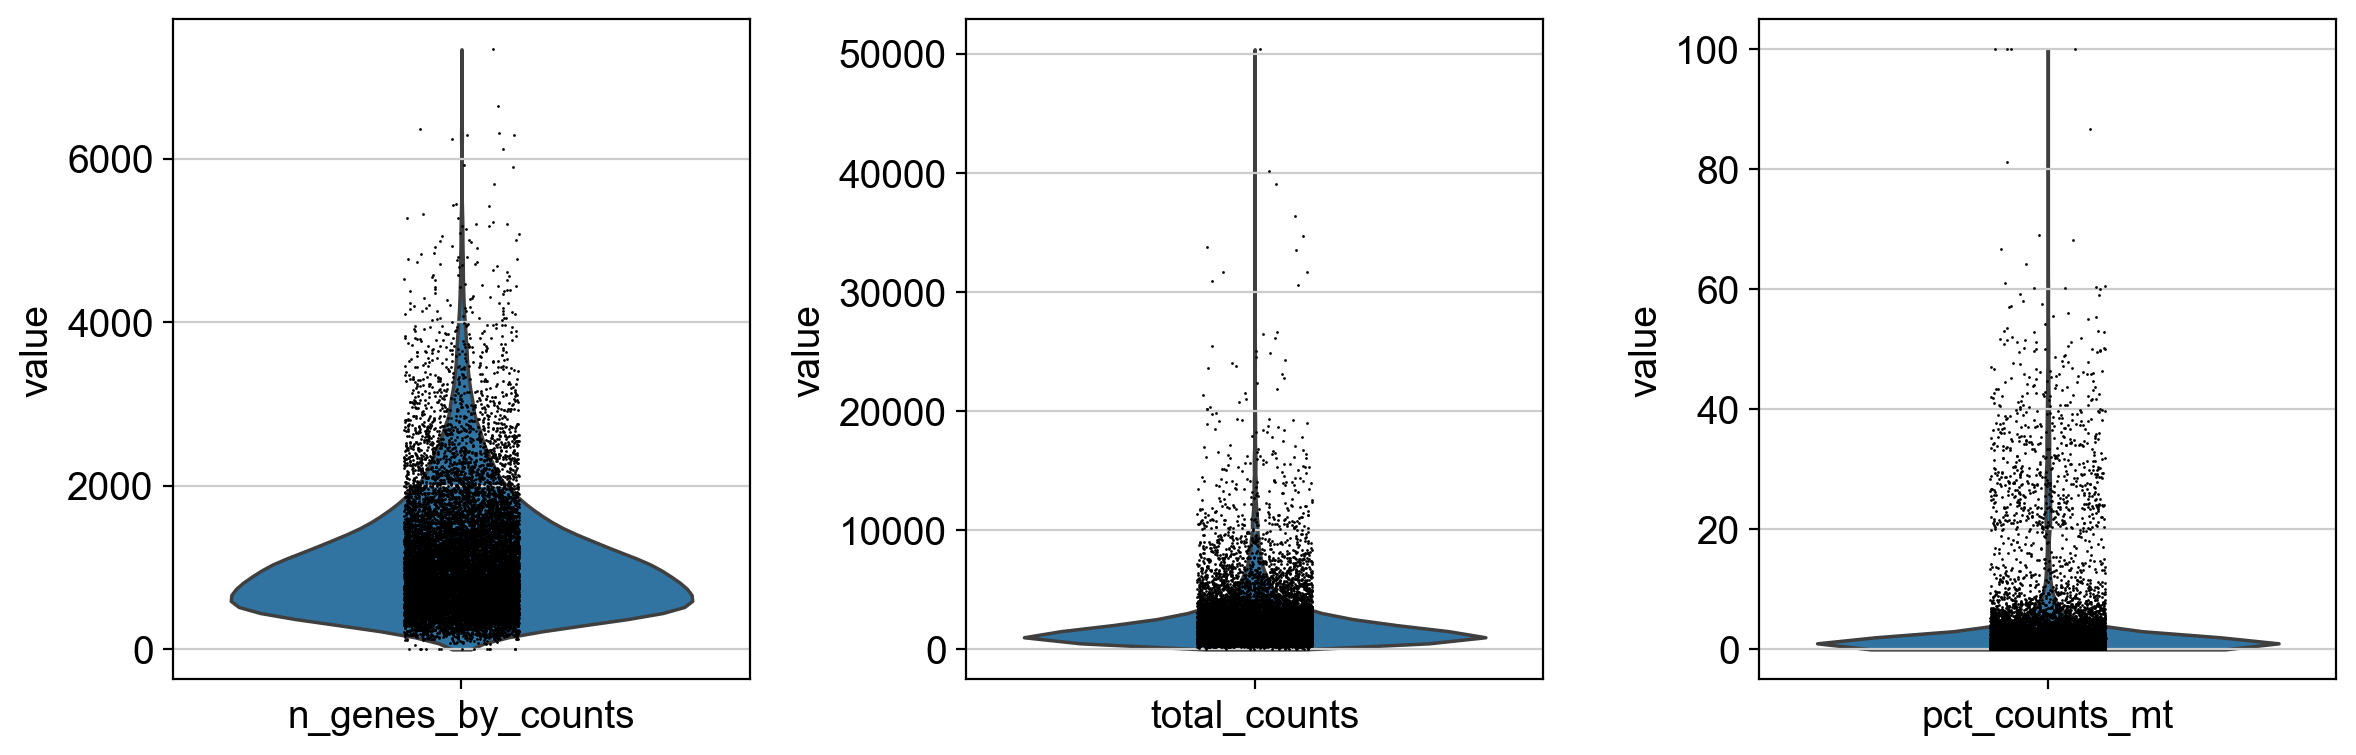

In [3]:
adata = adata[adata.obs['cell.type'] != 'discarded'].copy()

adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sc.pl.violin(adata, 'n_genes_by_counts', ax=axes[0], show=False)
sc.pl.violin(adata, 'total_counts', ax=axes[1], show=False)
sc.pl.violin(adata, 'pct_counts_mt', ax=axes[2], show=False)
plt.tight_layout()
plt.show()

In [4]:
adata = adata[adata.obs['n_genes_by_counts'] > 200]
adata = adata[adata.obs['n_genes_by_counts'] < 5000]
adata = adata[adata.obs['pct_counts_mt'] < 20]
sc.pp.filter_genes(adata, min_cells=10)

print(f'After QC: {adata.n_obs} cells, {adata.n_vars} genes')

After QC: 13396 cells, 21501 genes


## Normalization and Feature Selection

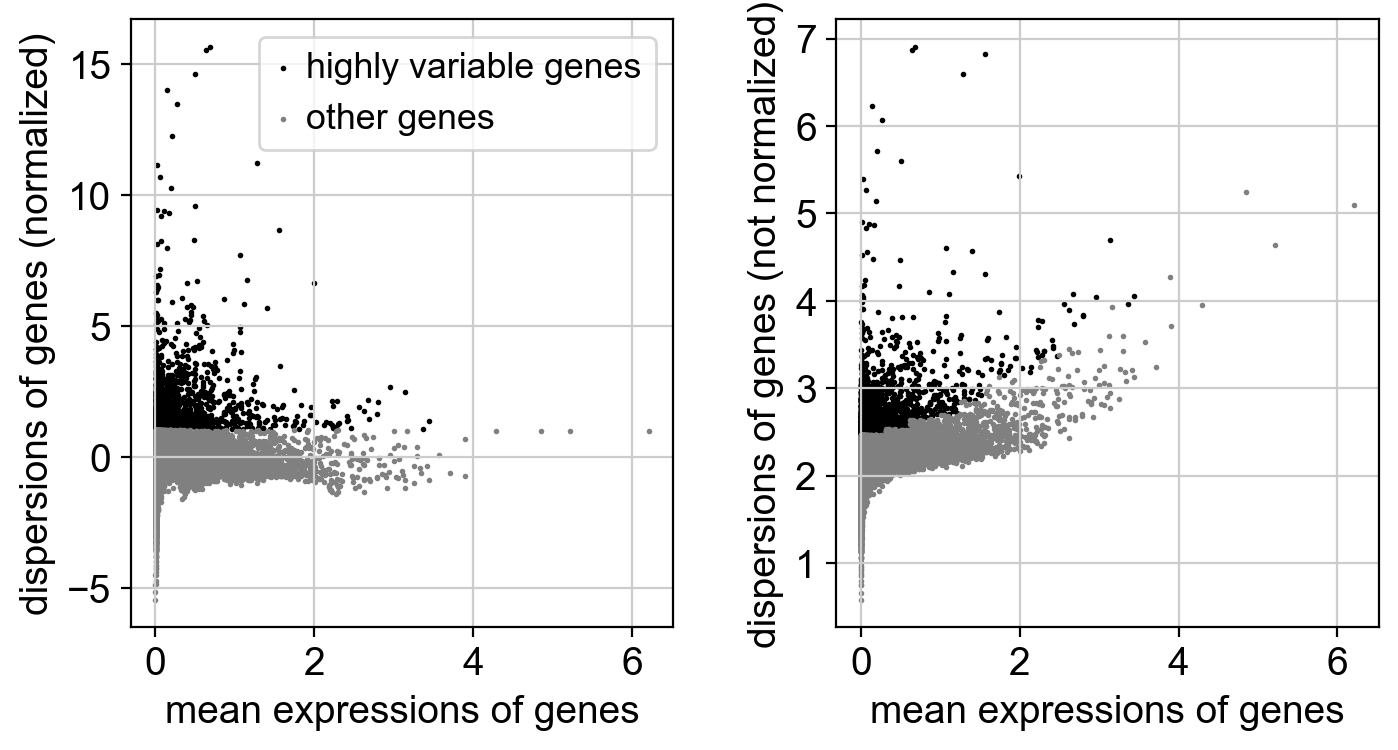

In [5]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [6]:
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)

## Dimensionality Reduction and Clustering

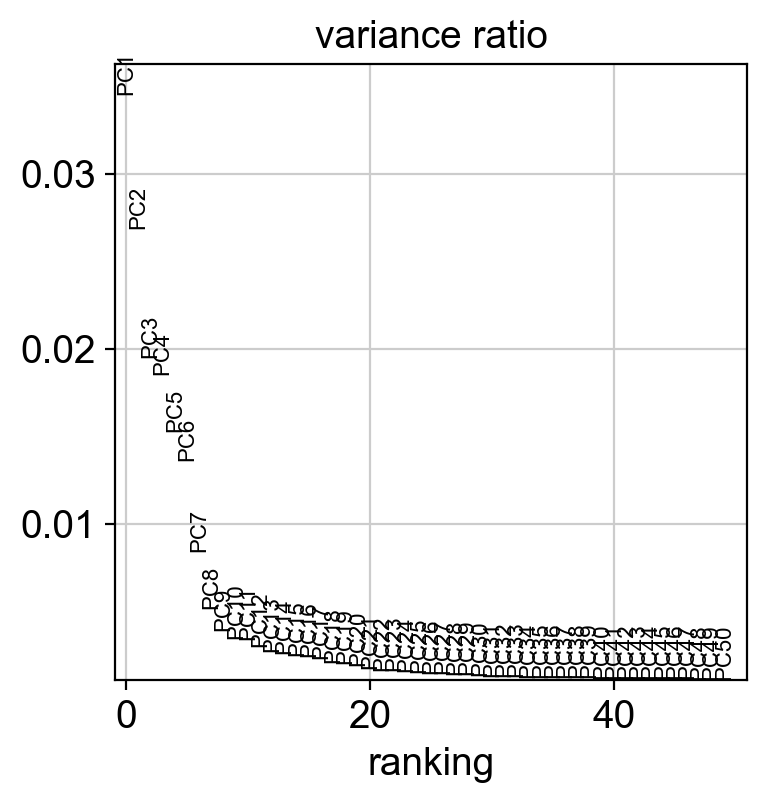

In [7]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca_variance_ratio(adata, n_pcs=50)

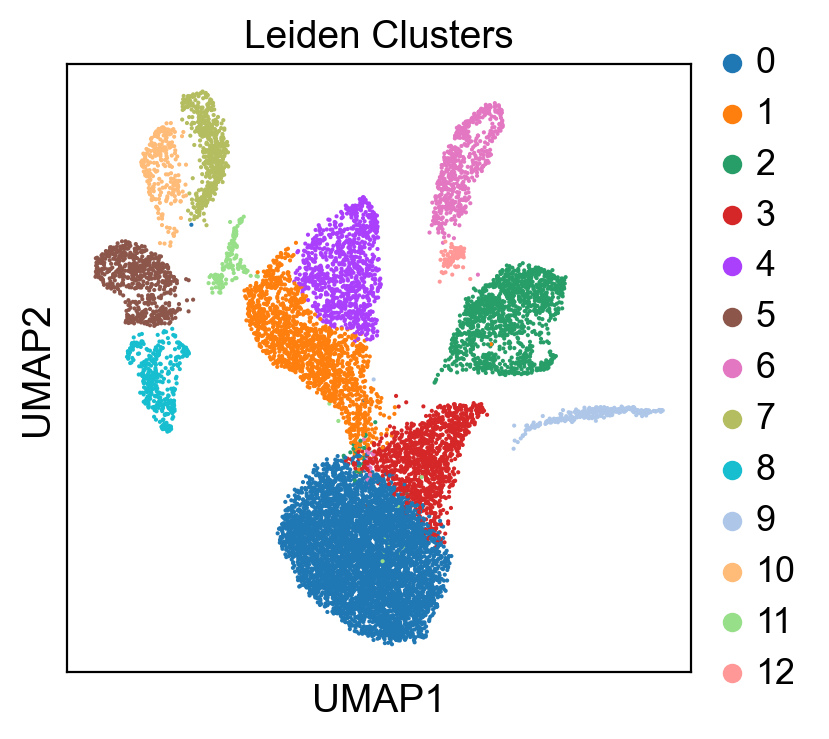

In [8]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)

sc.pl.umap(adata, color='leiden', title='Leiden Clusters')

## Marker Genes

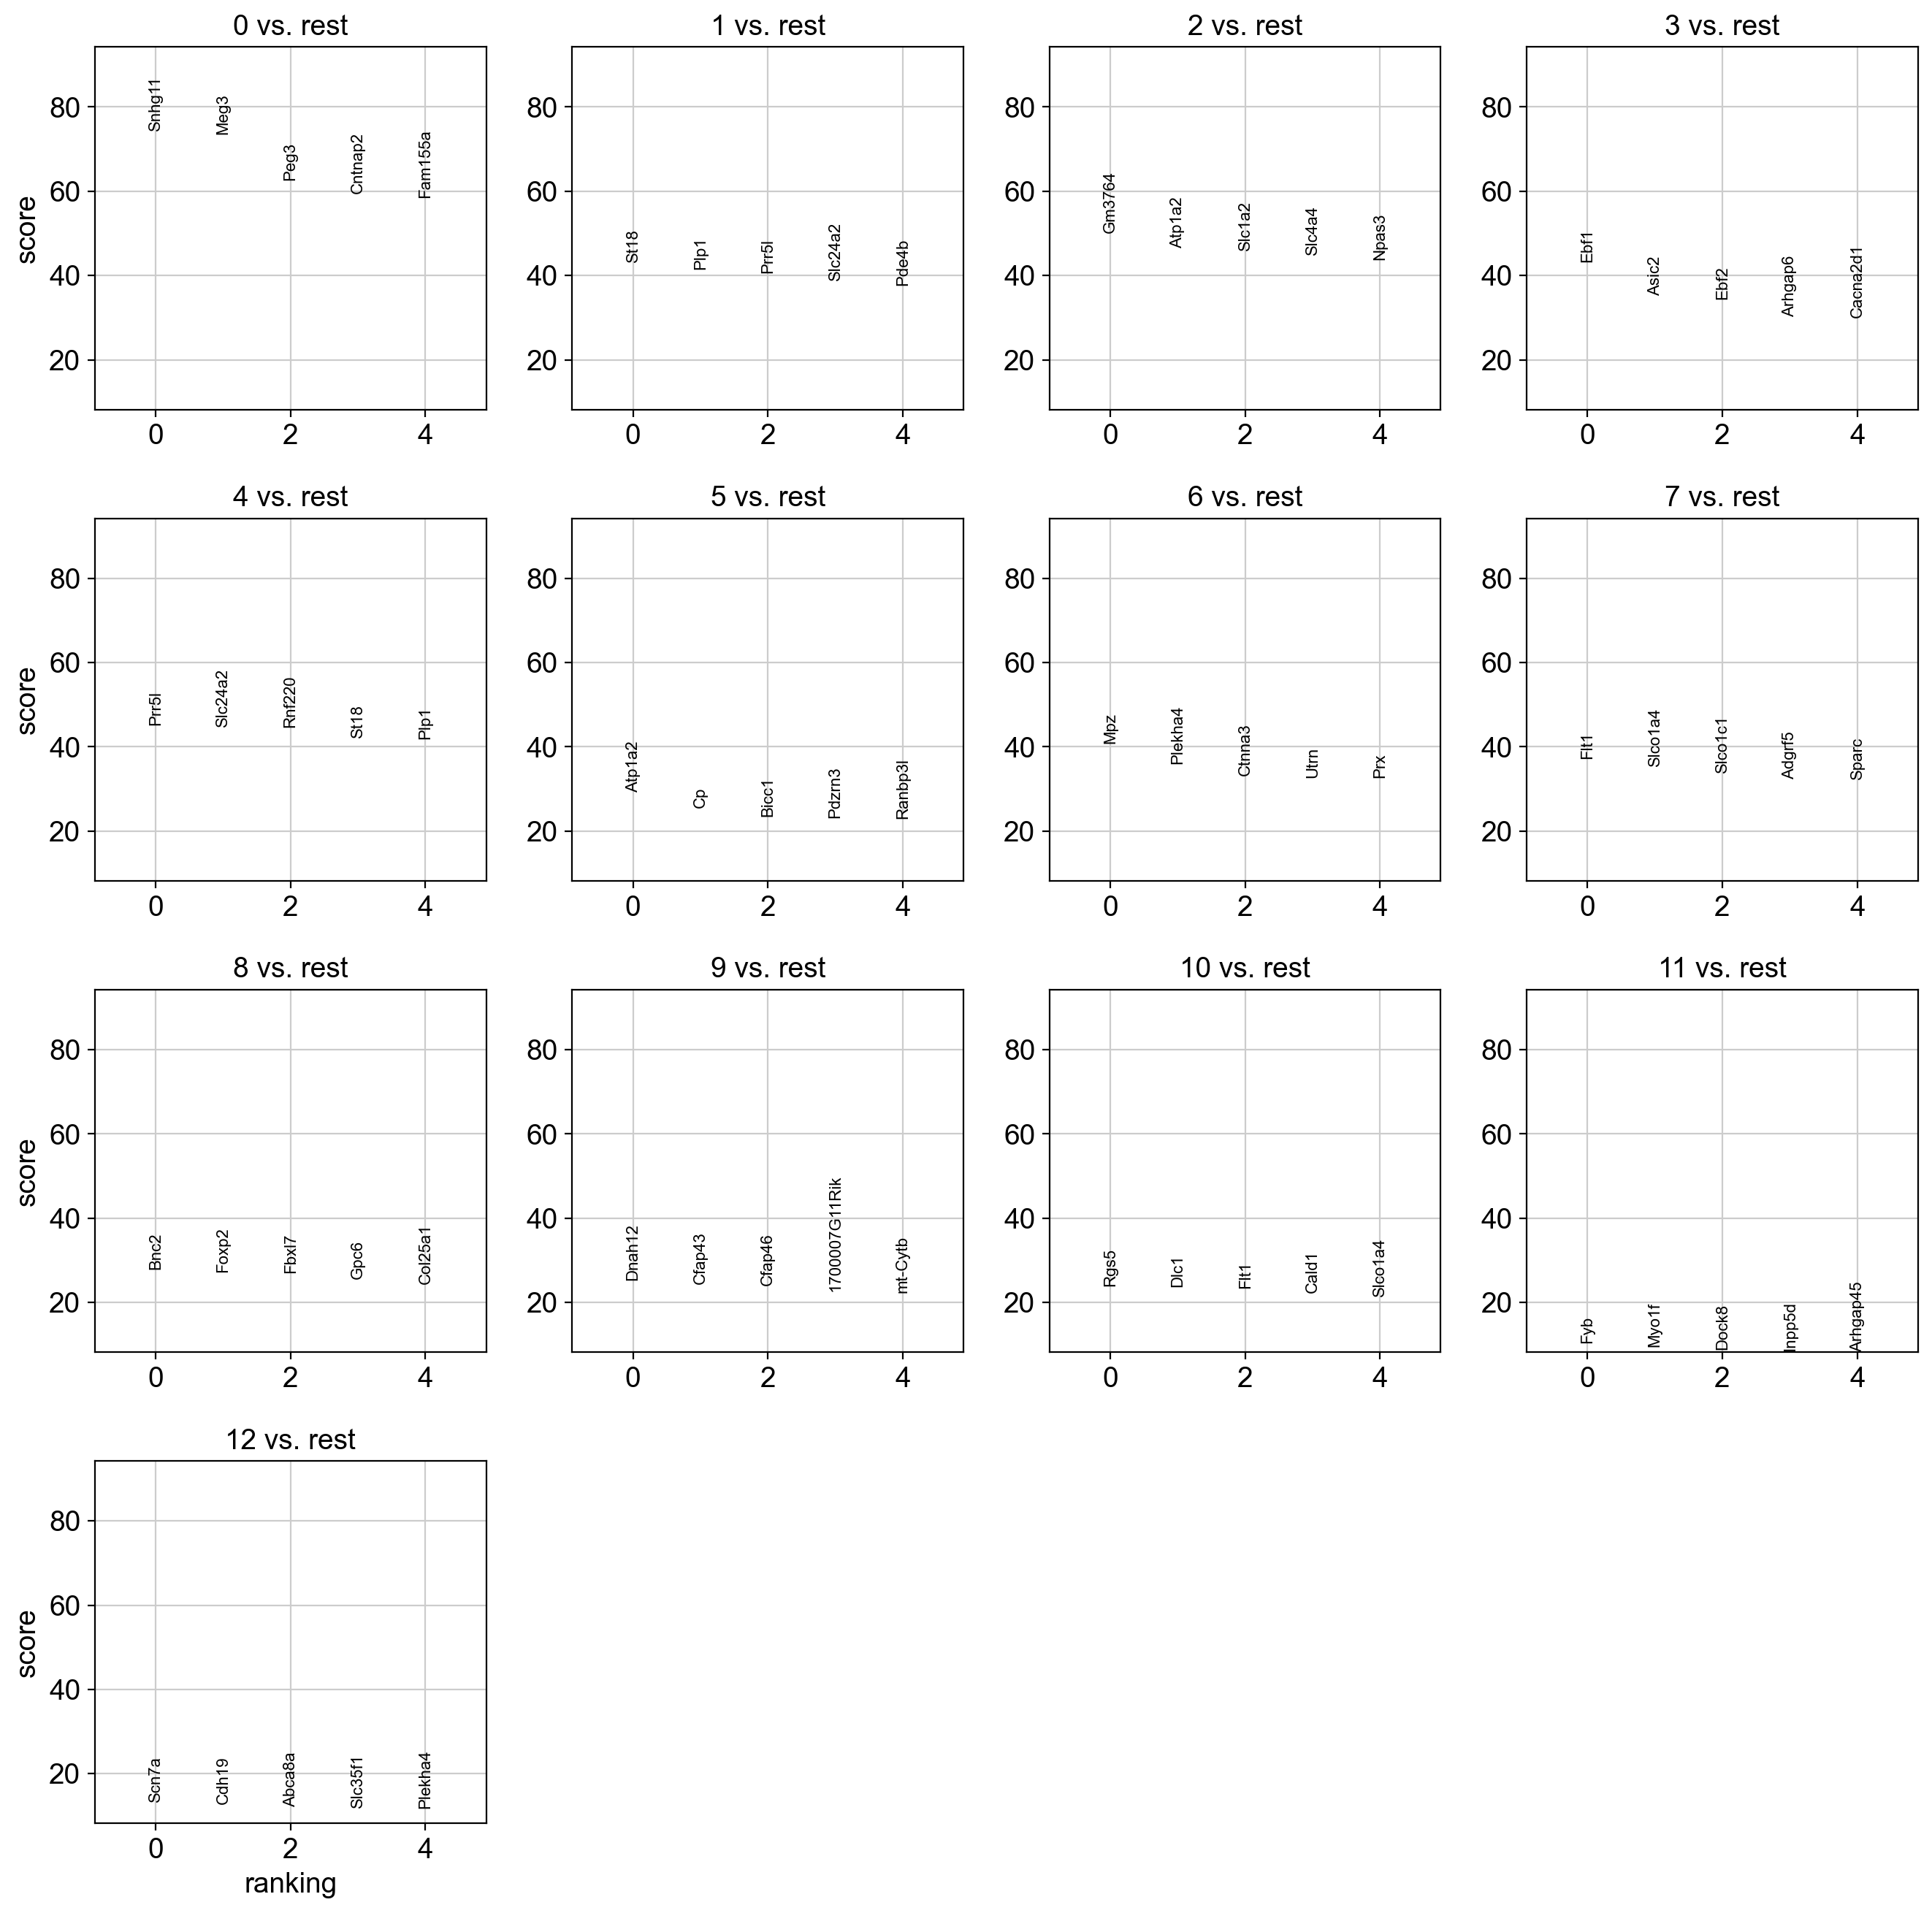

In [9]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=5)

In [10]:
marker_df = sc.get.rank_genes_groups_df(adata, group=None)
marker_df.groupby('group').head(3)[['group', 'names', 'scores']]

,group,names,scores
0,0,Snhg11,74.363243
1,0,Meg3,73.559761
2,0,Peg3,62.527542
21501,1,St18,43.110828
21502,1,Plp1,41.536819
21503,1,Prr5l,40.591225
43002,2,Gm3764,50.182644
43003,2,Atp1a2,46.427044
43004,2,Slc1a2,45.888008
64503,3,Ebf1,43.270508


## Cell Type Annotation

Compare our clusters to the authors' cell type labels.

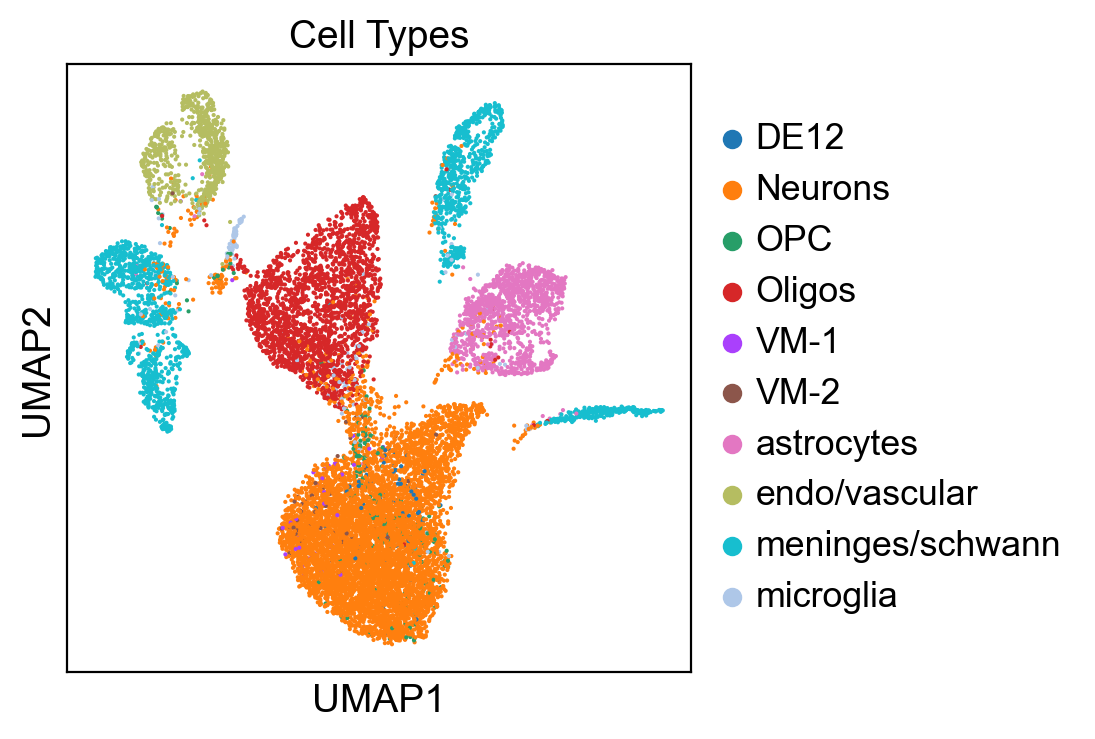

In [11]:
broad_types = adata.obs['cell.type'].astype(str).copy()
broad_types[broad_types.str.match('^[DVM][EI]-|^VC-|^VE-|^ME-|^MI-|^neurons')] = 'Neurons'
adata.obs['broad_type'] = broad_types

sc.pl.umap(adata, color='broad_type', title='Cell Types')

## Opioid Receptor Expression

Examining expression of mu (Oprm1), delta (Oprd1), and kappa (Oprk1) opioid receptors across cell types.

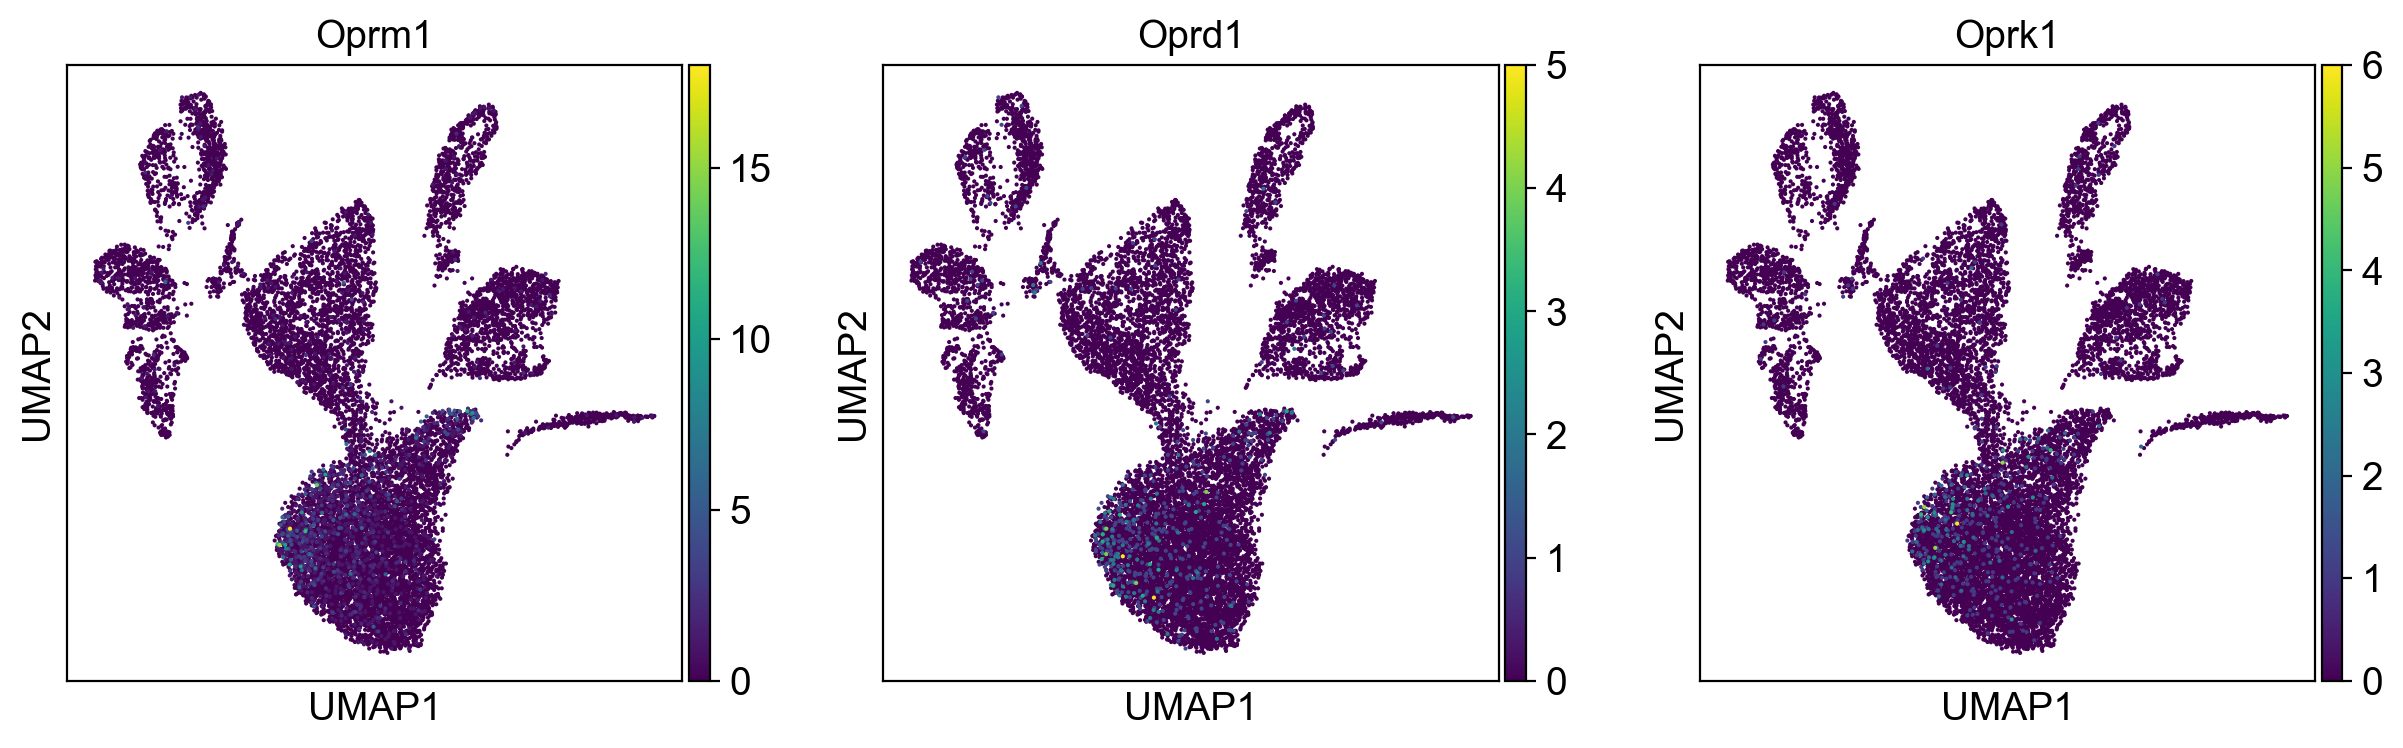

In [12]:
opioid_genes = ['Oprm1', 'Oprd1', 'Oprk1']
sc.pl.umap(adata, color=opioid_genes, use_raw=True, ncols=3)

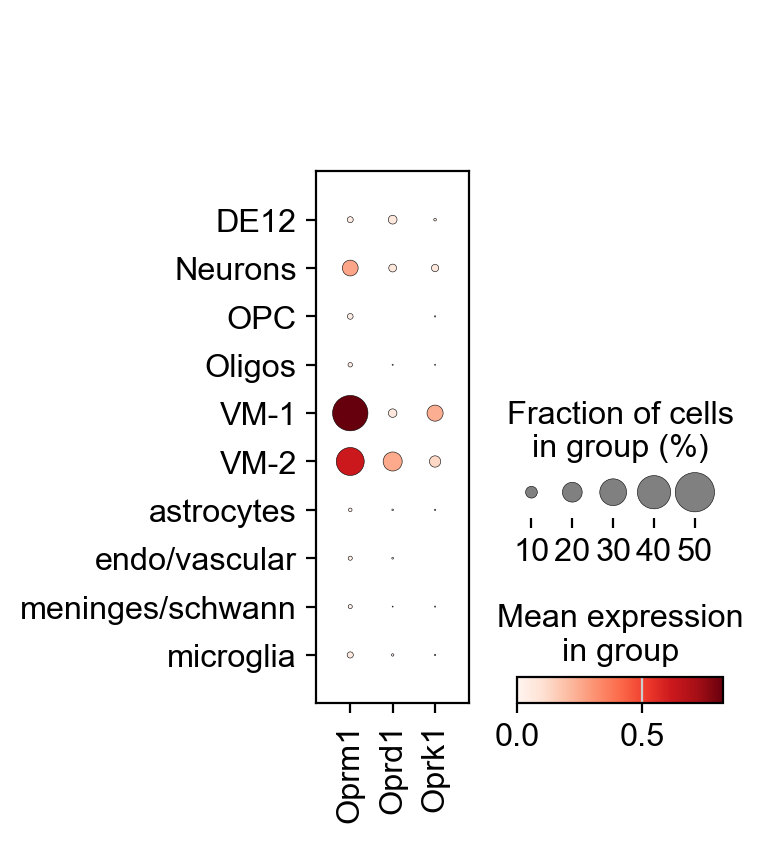

In [13]:
sc.pl.dotplot(adata, var_names=opioid_genes, groupby='broad_type', use_raw=True)

## Key Findings

- **13 clusters** identified corresponding to major spinal cord cell types
- **Oprm1 (mu opioid receptor)** is enriched in VM-1 and VM-2 ventral motor neuron populations
- Delta and kappa receptors show lower, more diffuse expression
- Our clusters align well with the authors' published annotations